# Accident Detection System

## 1. Introduction

dataset in use https://www.kaggle.com/datasets/fahaddalwai/cctvfootagevideo/data for this demo

## 2. Importing libraries

In [1]:
!pip install tensorflow

  Obtaining dependency information for numpy<2.1.0,>=1.26.0 from https://files.pythonhosted.org/packages/c1/ca/2f384720020c7b244d22508cb7ab23d95f179fcfff33c31a6eeba8d6c512/numpy-2.0.2-cp311-cp311-macosx_14_0_arm64.whl.metadata
  Using cached numpy-2.0.2-cp311-cp311-macosx_14_0_arm64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp311-cp311-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 2.0.2 which is incompatible.
scipy 1.11.1 requires nump

In [2]:
!pip install numpy==1.24.3

  Obtaining dependency information for numpy==1.24.3 from https://files.pythonhosted.org/packages/ee/6c/7217a8844dfe22e349bccbecd35571fa72c5d7fe8b33d8c5540e8cc2535c/numpy-1.24.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached numpy-1.24.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-macosx_11_0_arm64.whl (13.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


In [4]:
# frame extraction

def extract_frames(video_path, frames_dir, skip_frames=1):
    """
    Extract frames from a video and save them as images.

    Parameters:
    - video_path: Path to the video file.
    - frames_dir: Directory to save extracted frames.
    - skip_frames: Extract every nth frame to reduce data size.
    """
    os.makedirs(frames_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")

    for _ in tqdm(range(total_frames), desc="Extracting frames"):
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % skip_frames == 0:
            frame_path = os.path.join(frames_dir, f"frame_{frame_count:05d}.jpg")
            cv2.imwrite(frame_path, frame)
            saved_count += 1
        frame_count += 1

    cap.release()
    print(f"Extracted and saved {saved_count} frames.")

# Parameters
video_path = './data/raw_video.mp4'
frames_dir = './data/frames/'
skip_frames = 5  # Extract every 5th frame to reduce data size

# Extract frames
extract_frames(video_path, frames_dir, skip_frames)

[ WARN:0@6.582] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@6.582] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@6.582] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@6.582] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/c

Total frames in video: 2298


Extracting frames: 100%|███████████████████| 2298/2298 [00:03<00:00, 762.79it/s]

Extracted and saved 460 frames.


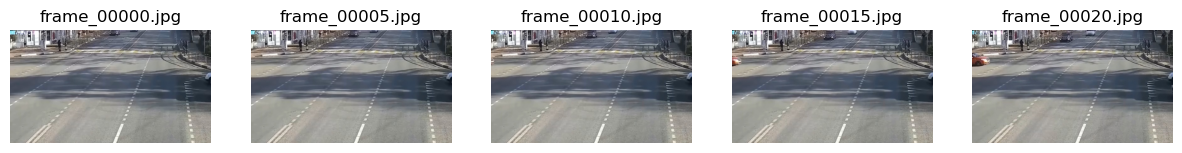

In [5]:
## annotation

# Initialize an empty DataFrame for annotations
annotations = pd.DataFrame(columns=['frame_number', 'label'])

# List all frame files
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

# Display sample frames for manual labeling
num_samples = 5
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    img = cv2.imread(os.path.join(frames_dir, frame_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"{frame_files[i]}")
    plt.axis('off')
plt.show()


In [2]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# 1. Define Paths and Parameters
train_dir = 'data_new/train'
val_dir = 'data_new/val'
test_dir = 'data_new/test'

img_height = 250
img_width = 250
batch_size = 100

In [3]:
# 2. Load Datasets with `image_dataset_from_directory`
# This approach automatically handles batching and shuffling

training_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

# Save class names before applying performance optimizations
class_names = training_data.class_names

Found 2726 files belonging to 2 classes.
Found 26 files belonging to 2 classes.
Found 29 files belonging to 2 classes.


In [4]:
# 3. Configure Dataset for Performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
# 4. Define the CNN Model
model = models.Sequential([
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.5127 - loss: 2.2843 - val_accuracy: 0.5385 - val_loss: 0.6927
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 191s 7s/step - accuracy: 0.6219 - loss: 0.6464 - val_accuracy: 0.6538 - val_loss: 0.6865
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 272s 10s/step - accuracy: 0.6893 - loss: 0.5840 - val_accuracy: 0.7308 - val_loss: 0.6348
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - accuracy: 0.7771 - loss: 0.4851 - val_accuracy: 0.7692 - val_loss: 0.5476
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.8416 - loss: 0.3686 - val_accuracy: 0.7692 - val_loss: 0.5217
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.8816 - loss: 0.2797 - val_accuracy: 0.8077 - val_loss: 0.5199
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.9139 - loss: 0.2129 - val_accuracy: 0.8077 - val_loss: 0.4590
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.9302 - loss: 0.1689 - val_accuracy: 0.8077 - 

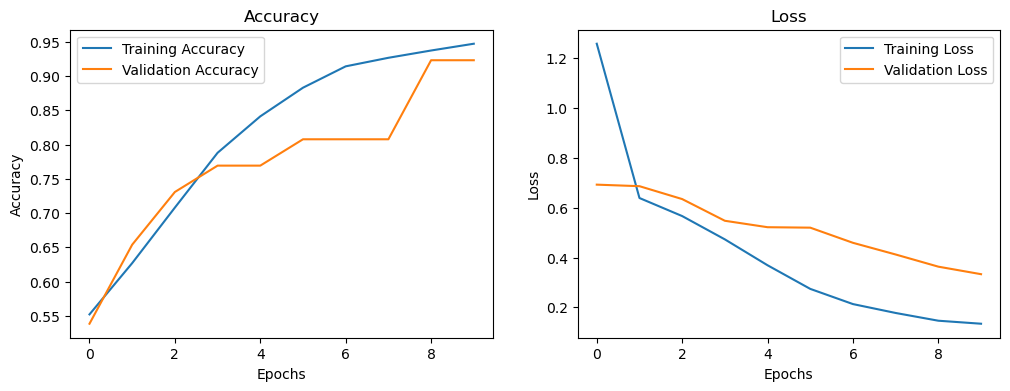

In [6]:
# 7. Plot Training and Validation Metrics

history = model.fit(training_data, validation_data=validation_data, epochs=10)

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step - accuracy: 0.8966 - loss: 0.2408
Test Accuracy: 0.90
Test Loss: 0.24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


2024-11-24 15:32:10.713550: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


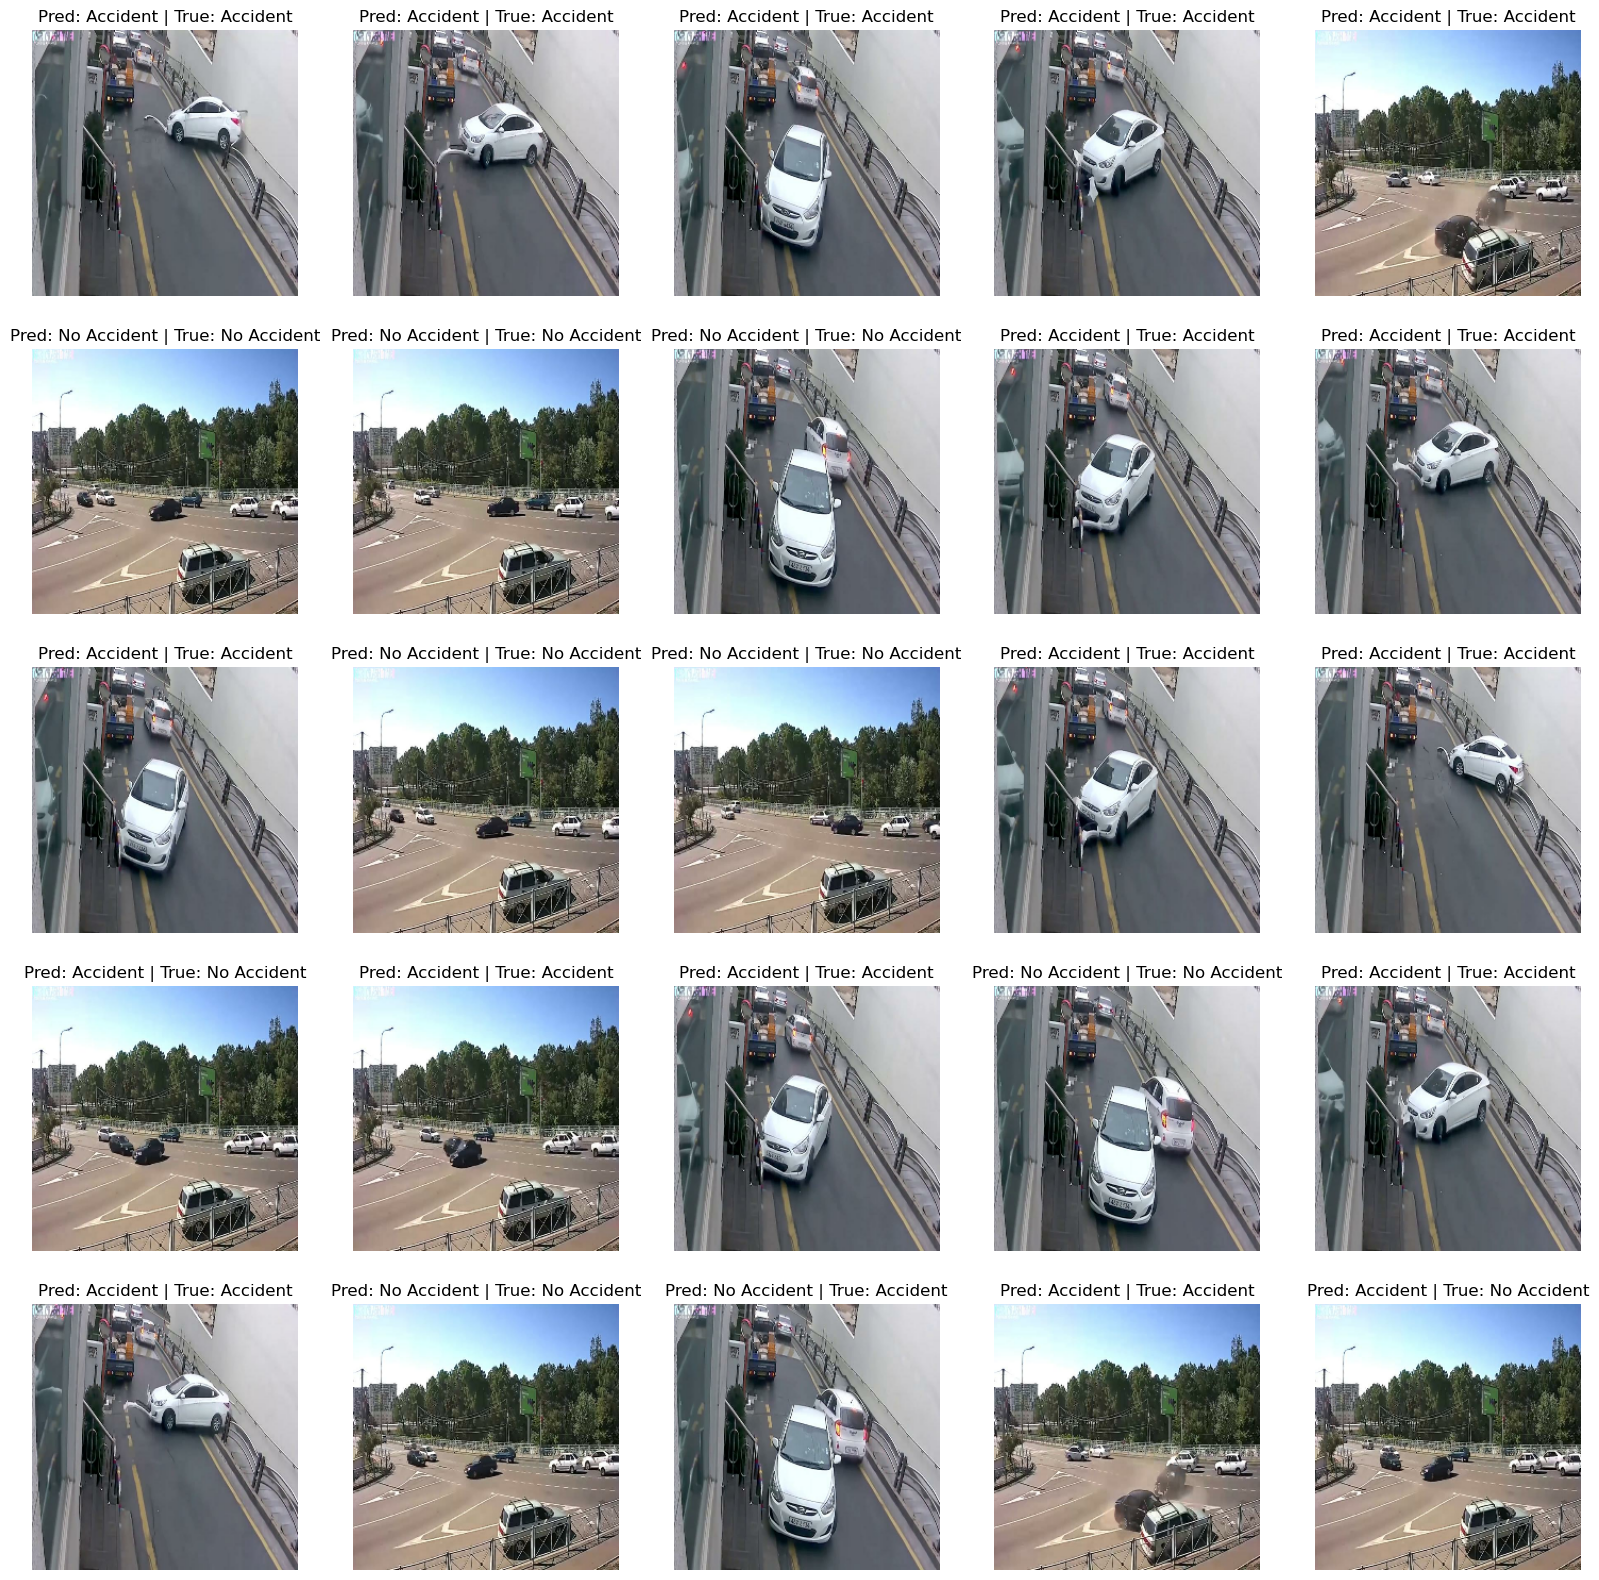

In [7]:
# 8. Evaluate on Testing Data
test_loss, test_accuracy = model.evaluate(testing_data)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# 9. Visualize Predictions on Testing Data
plt.figure(figsize=(20, 20))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    pred_labels = [class_names[np.argmax(pred)] for pred in predictions]
    true_labels = [class_names[label] for label in labels]

    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {pred_labels[i]} | True: {true_labels[i]}")
        plt.axis("off")

plt.show()


In [8]:
test_loss, test_accuracy = model.evaluate(testing_data)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8966 - loss: 0.2408
Test Accuracy: 0.90
Test Loss: 0.24


In [9]:
# Save the trained model
model.save("accident_detection_model.keras")

In [10]:
predictions

array([[0.99504   , 0.00495999],
       [0.9914563 , 0.0085438 ],
       [0.97032833, 0.02967161],
       [0.93717295, 0.06282709],
       [0.95574725, 0.04425276],
       [0.2935055 , 0.70649445],
       [0.15303837, 0.8469617 ],
       [0.06504539, 0.9349546 ],
       [0.922429  , 0.07757097],
       [0.99035394, 0.00964598],
       [0.98437256, 0.01562747],
       [0.29698247, 0.70301753],
       [0.20690136, 0.79309875],
       [0.8723525 , 0.12764753],
       [0.9904307 , 0.00956932],
       [0.7407114 , 0.25928855],
       [0.8948121 , 0.10518789],
       [0.97502184, 0.02497814],
       [0.08661576, 0.91338414],
       [0.9799814 , 0.02001852],
       [0.98569894, 0.01430113],
       [0.2894772 , 0.71052283],
       [0.1493562 , 0.85064375],
       [0.9589774 , 0.04102261],
       [0.70703137, 0.29296854],
       [0.9924451 , 0.00755499],
       [0.9571235 , 0.04287642],
       [0.20506296, 0.7949371 ],
       [0.9925647 , 0.00743535]], dtype=float32)

In [11]:
# 9. Visualize Predictions on Testing Data
print(testing_data.take(1))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    print(predictions)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
[[0.99504    0.00495999]
 [0.9914563  0.0085438 ]
 [0.97032833 0.02967161]
 [0.93717295 0.06282709]
 [0.95574725 0.04425276]
 [0.2935055  0.70649445]
 [0.15303837 0.8469617 ]
 [0.06504539 0.9349546 ]
 [0.922429   0.07757097]
 [0.99035394 0.00964598]
 [0.98437256 0.01562747]
 [0.29698247 0.70301753]
 [0.20690136 0.79309875]
 [0.8723525  0.12764753]
 [0.9904307  0.00956932]
 [0.7407114  0.25928855]
 [0.8948121  0.10518789]
 [0.97502184 0.02497814]
 [0.08661576 0.91338414]
 [0.9799814  0.02001852]
 [0.98569894 0.01430113]
 [0.2894772  0.71052283]
 [0.1493562  0.85064375]
 [0.9589774  0.04102261]
 [0.70703137 0.29296854]
 [0.9924451  0.00755499]
 [0.9571235  0.04287642]
 [0.20506296 0.7949371 ]
 [0.9925647  0.00743535]]


2024-11-24 15:33:45.948158: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
# Save a test image from the dataset for consistent testing
for images, labels in testing_data.take(1):
    tf.keras.preprocessing.image.save_img("test_image.jpg", images[0])  # Saves the first image in the batch
    break


In [26]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [31]:
# Save model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to a .weights.h5 file
model.save_weights("model.weights.h5")


In [33]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
loaded_model = load_model("accident_detection1_model.keras")

# Compare predictions on a sample batch from your test data
for images, labels in testing_data.take(1):
    original_predictions = model.predict(images)  # Predictions from the original model
    loaded_model_predictions = loaded_model.predict(images)  # Predictions from the loaded model

    # Check if both sets of predictions are the same
    print("Original Model Predictions:\n", original_predictions)
    print("Loaded Model Predictions:\n", loaded_model_predictions)

    # Optionally, calculate and print the difference between the predictions
    difference = np.abs(original_predictions - loaded_model_predictions)
    print("Difference between original and loaded model predictions:\n", difference)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
Original Model Predictions:
 [[1.15955146e-07 9.99999881e-01]
 [8.95900488e-01 1.04099564e-01]
 [9.92442906e-01 7.55703682e-03]
 [8.77237216e-09 1.00000000e+00]
 [9.71056283e-01 2.89436430e-02]
 [1.98088790e-04 9.99801874e-01]
 [2.95364327e-04 9.99704719e-01]
 [8.52616893e-07 9.99999166e-01]
 [1.61033645e-02 9.83896554e-01]
 [3.07479064e-09 1.00000000e+00]
 [8.80256891e-01 1.19743064e-01]
 [2.13027060e-01 7.86973000e-01]
 [2.99250660e-05 9.99970138e-01]
 [9.94776905e-01 5.22319507e-03]
 [9.99981940e-01 1.81290598e-05]
 [3.53935212e-01 6.46064818e-01]
 [9.99985337e-01 1.46277289e-05]
 [9.99069929e-01 9.30011156e-04]
 [1.15027666e-04 9.99884963e-01]
 [2.29717648e-06 9.99997735e-01]
 [9.93080139e-01 6.91988273e-03]
 [9.99985576e-01 1.44057858e-05]
 [2.87142630e-05 9.99971330e-01]
 [2.33629631e-04 9.99766350e-01]
 [2.66666547e-03 9.97333348e-01]
 [8.83567572e-01 1.16432436e-01]
 [1.44555641e-04 9.99855459e-01]
 [

In [36]:
frames_dir = './data_new/frames/'  # Directory containing the frames extracted from the video
import os

accident_frames_dir = './data_new/predicted/accident/'
non_accident_frames_dir = './data_new/predicted/non_accident/'

os.makedirs(accident_frames_dir, exist_ok=True)
os.makedirs(non_accident_frames_dir, exist_ok=True)


In [37]:
import numpy as np
from tensorflow.keras.preprocessing import image
import shutil
from tqdm import tqdm

# Load the best model
from tensorflow.keras.models import load_model
model = load_model("accident_detection_model.keras")

In [38]:
# Classify frames
for frame_file in tqdm(frame_files, desc="Classifying frames"):
    img_path = os.path.join(frames_dir, frame_file)
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Predict
    prediction = model.predict(img_array)[0]  # Get the probabilities for both classes
    
    
    print("PRediction", prediction)
    
    # Get the predicted class index
    predicted_class = np.argmax(prediction)  # Returns 0 or 1
    
    # Map predicted class to label and destination directory
    if predicted_class > 0.5:
        label = 'Non Accident'
        dest_dir = accident_frames_dir
    else:
        label = 'Accident'
        dest_dir = non_accident_frames_dir
    
    # Move the frame to the corresponding folder
    shutil.move(img_path, os.path.join(dest_dir, frame_file))


Classifying frames:   0%|                               | 0/460 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Classifying frames:   0%|                       | 1/460 [00:00<00:52,  8.81it/s]

PRediction [0.19100796 0.8089921 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.9469866  0.05301336]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.00231324 0.99768674]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:   1%|▏                      | 4/460 [00:00<00:24, 18.62it/s]

PRediction [0.07091427 0.92908573]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.15588222 0.8441178 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.65731716 0.3426828 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:   2%|▎                      | 7/460 [00:00<00:21, 20.68it/s]

PRediction [0.08665497 0.913345  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.14354406 0.8564559 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.9466656  0.05333447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:   2%|▍                     | 10/460 [00:00<00:20, 21.91it/s]

PRediction [0.95484877 0.04515119]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.18092342 0.8190766 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.7992211  0.20077886]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:   3%|▌                     | 13/460 [00:00<00:20, 21.79it/s]

PRediction [0.96687686 0.03312317]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.9034805  0.09651943]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.00440844 0.9955916 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:   3%|▊                     | 16/460 [00:00<00:20, 21.81it/s]

PRediction [9.9989891e-01 1.0107219e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
PRediction [9.9972838e-01 2.7157244e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.00340712 0.9965928 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Classifying frames:   4%|▉                     | 19/460 [00:00<00:21, 20.73it/s]

PRediction [0.8819196 0.1180803]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.9655961  0.03440399]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.9225551  0.07744493]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
PRediction

Classifying frames:   5%|█                     | 22/460 [00:01<00:24, 18.17it/s]

 [0.941844   0.05815604]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
PRediction [0.10112271 0.8988773 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Classifying frames:   5%|█▏                    | 24/460 [00:01<00:37, 11.63it/s]

PRediction [0.7336152 0.2663848]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
PRediction [0.18792135 0.8120786 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:   6%|█▏                    | 26/460 [00:01<00:34, 12.66it/s]

PRediction [0.12704189 0.8729581 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.13474753 0.8652525 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.836351   0.16364896]


Classifying frames:   6%|█▎                    | 28/460 [00:01<00:33, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.1258599  0.87414014]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Classifying frames:   7%|█▍                    | 30/460 [00:01<00:33, 12.75it/s]

PRediction [0.00408517 0.9959149 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
PRediction [0.9382983  0.06170171]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:   7%|█▌                    | 32/460 [00:02<00:31, 13.38it/s]

PRediction [0.21418144 0.7858185 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
PRediction [0.23607868 0.7639213 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:   7%|█▋                    | 34/460 [00:02<00:32, 13.09it/s]

PRediction [0.881547   0.11845305]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.02376825 0.97623175]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.36446494 0.63553506]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:   8%|█▊                    | 37/460 [00:02<00:27, 15.66it/s]

PRediction [0.01652547 0.98347455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.12086201 0.879138  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.7007733  0.29922667]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Classifying frames:   9%|█▉                    | 40/460 [00:02<00:25, 16.26it/s]

PRediction [0.06079205 0.9392079 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.12796886 0.8720311 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.6166584  0.38334164]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:   9%|██                    | 43/460 [00:02<00:23, 17.58it/s]

PRediction [0.8118876  0.18811235]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.93153834 0.0684617 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.81732917 0.18267088]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  10%|██▏                   | 46/460 [00:02<00:21, 18.90it/s]

PRediction [0.94720066 0.05279939]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
PRediction [0.0394754 0.9605246]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.18696211 0.81303793]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  11%|██▎                   | 49/460 [00:02<00:20, 19.82it/s]

PRediction [0.3078415 0.6921585]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.6505538 0.3494462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
PRediction [0.13890243 0.86109763]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  11%|██▍                   | 52/460 [00:03<00:20, 20.09it/s]

PRediction [0.14396815 0.85603184]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.73054856 0.2694514 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.01141206 0.988588  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  12%|██▋                   | 55/460 [00:03<00:19, 20.56it/s]

PRediction [0.84869576 0.15130427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
PRediction [0.36595994 0.63404006]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.9070195  0.09298053]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  13%|██▊                   | 58/460 [00:03<00:20, 19.23it/s]

PRediction [0.27076322 0.72923684]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
PRediction [0.0635638  0.93643624]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Classifying frames:  13%|██▊                   | 60/460 [00:03<00:22, 18.00it/s]

PRediction [0.00852084 0.9914792 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
PRediction [0.16429648 0.8357035 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.09337588 0.90662414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  14%|███                   | 63/460 [00:03<00:20, 18.96it/s]

PRediction [0.47406986 0.5259301 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.32979128 0.67020875]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.11328693 0.8867131 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  14%|███▏                  | 66/460 [00:03<00:19, 20.33it/s]

PRediction [0.84995073 0.15004934]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.95503837 0.0449616 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
PRediction [0.03447559 0.9655244 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  15%|███▎                  | 69/460 [00:03<00:19, 20.33it/s]

PRediction [0.02852186 0.97147816]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.8186806 0.1813194]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.9428707 0.0571293]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  16%|███▍                  | 72/460 [00:04<00:18, 20.97it/s]

PRediction [0.12325459 0.8767454 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.23823571 0.7617643 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.58146036 0.41853967]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  16%|███▌                  | 75/460 [00:04<00:17, 21.52it/s]

PRediction [0.09402674 0.9059732 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.83702135 0.16297868]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.01584181 0.98415816]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  17%|███▋                  | 78/460 [00:04<00:17, 22.06it/s]

PRediction [0.00596235 0.9940376 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.42950934 0.5704906 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.7295018  0.27049822]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  18%|███▊                  | 81/460 [00:04<00:16, 22.50it/s]

PRediction [0.94497305 0.05502691]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.9968546  0.00314544]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.00121946 0.99878055]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  18%|████                  | 84/460 [00:04<00:16, 22.53it/s]

PRediction [0.1716928  0.82830715]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.21579607 0.7842039 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.09700236 0.9029977 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  19%|████▏                 | 87/460 [00:04<00:16, 22.30it/s]

PRediction [0.07847019 0.9215299 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.06317556 0.93682444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.9025642 0.0974358]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  20%|████▎                 | 90/460 [00:04<00:16, 22.61it/s]

PRediction [0.39790225 0.60209775]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.92172295 0.07827701]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.48000082 0.5199991 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  20%|████▍                 | 93/460 [00:04<00:16, 22.55it/s]

PRediction [0.8963474  0.10365256]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PRediction [0.9494336  0.05056638]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [9.999497e-01 5.036019e-05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  21%|████▌                 | 96/460 [00:05<00:16, 21.99it/s]

PRediction [0.00447322 0.99552673]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
PRediction [0.00315936 0.9968406 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PRediction [9.9959654e-01 4.0344676e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  22%|████▋                 | 99/460 [00:05<00:16, 21.61it/s]

PRediction [9.992939e-01 7.060855e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.87597096 0.12402904]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.87011635 0.12988369]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  22%|████▋                | 102/460 [00:05<00:16, 22.17it/s]

PRediction [0.89354086 0.10645916]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.9570757  0.04292426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.14668632 0.85331374]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  23%|████▊                | 105/460 [00:05<00:15, 22.38it/s]

PRediction [0.14105074 0.85894924]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
PRediction [0.36651278 0.6334872 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
PRediction [0.1195882  0.88041186]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.1550611 0.8449389]


Classifying frames:  23%|████▉                | 108/460 [00:05<00:16, 21.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.95756453 0.04243548]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PRediction [0.00282218 0.99717784]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  24%|█████                | 111/460 [00:05<00:16, 21.61it/s]

PRediction [0.22299269 0.7770073 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.94265395 0.05734598]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.37170848 0.62829155]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  25%|█████▏               | 114/460 [00:05<00:15, 22.19it/s]

PRediction [0.64366764 0.3563324 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.57344186 0.42655814]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.83093256 0.16906747]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  25%|█████▎               | 117/460 [00:06<00:15, 22.60it/s]

PRediction [0.02793028 0.97206974]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.08068707 0.9193129 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.94291675 0.05708325]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  26%|█████▍               | 120/460 [00:06<00:14, 22.75it/s]

PRediction [0.94582117 0.05417879]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.6093364 0.3906637]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.9867671  0.01323283]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  27%|█████▌               | 123/460 [00:06<00:14, 23.01it/s]

PRediction [0.9185373 0.0814627]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.94888526 0.05111475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.98882467 0.01117531]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  27%|█████▊               | 126/460 [00:06<00:14, 22.87it/s]

PRediction [0.9914146  0.00858537]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.9099038  0.09009618]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.6177013 0.3822987]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  28%|█████▉               | 129/460 [00:06<00:14, 22.83it/s]

PRediction [0.9455147  0.05448528]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.8640202  0.13597979]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.07418687 0.9258132 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  29%|██████               | 132/460 [00:06<00:14, 22.81it/s]

PRediction [0.01443589 0.9855641 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.9837046  0.01629542]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.5412618 0.4587383]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  29%|██████▏              | 135/460 [00:06<00:14, 23.09it/s]

PRediction [0.75402457 0.24597538]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.36257654 0.63742346]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.98840815 0.01159184]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  30%|██████▎              | 138/460 [00:06<00:13, 23.24it/s]

PRediction [0.9447972  0.05520278]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.42031285 0.5796872 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.99838006 0.00161997]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  31%|██████▍              | 141/460 [00:07<00:13, 23.21it/s]

PRediction [0.07256251 0.9274375 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.12052368 0.8794763 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.9818302  0.01816983]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  31%|██████▌              | 144/460 [00:07<00:13, 23.00it/s]

PRediction [0.01698817 0.98301184]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.15165131 0.8483486 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
PRediction [0.02385775 0.9761422 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  32%|██████▋              | 147/460 [00:07<00:14, 21.90it/s]

PRediction [0.96386224 0.03613769]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.8904347  0.10956535]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.8696416  0.13035846]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  33%|██████▊              | 150/460 [00:07<00:13, 22.54it/s]

PRediction [0.97709846 0.02290156]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.652223 0.347777]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [9.9973994e-01 2.6004633e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  33%|██████▉              | 153/460 [00:07<00:13, 22.43it/s]

PRediction [9.9965465e-01 3.4540301e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.93797576 0.0620243 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.9591551 0.040845 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  34%|███████              | 156/460 [00:07<00:13, 22.26it/s]

PRediction [0.9855907 0.0144093]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.9101599  0.08984014]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.7519159  0.24808416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  35%|███████▎             | 159/460 [00:07<00:13, 22.46it/s]

PRediction [0.9624158  0.03758415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
PRediction [0.02547417 0.9745258 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.01221497 0.987785  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying frames:  35%|███████▍             | 162/460 [00:08<00:13, 21.35it/s]

PRediction [0.10405453 0.89594555]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
PRediction [0.94989014 0.05010991]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
PRediction [0.06775262 0.9322474 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Classifying frames:  36%|███████▌             | 165/460 [00:08<00:15, 19.49it/s]

PRediction [0.998618   0.00138199]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
PRediction [0.22442712 0.7755729 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Classifying frames:  36%|███████▌             | 167/460 [00:08<00:15, 18.93it/s]

PRediction [0.94545    0.05454998]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
PRediction [0.98863924 0.0113607 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  37%|███████▋             | 169/460 [00:08<00:15, 18.82it/s]

PRediction [0.9430855 0.0569145]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
PRediction [0.99321234 0.00678769]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  37%|███████▊             | 171/460 [00:08<00:15, 18.47it/s]

PRediction [0.99855334 0.0014467 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PRediction [0.30821627 0.6917837 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  38%|███████▉             | 173/460 [00:08<00:18, 15.50it/s]

PRediction [0.12819481 0.8718052 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
PRediction [0.98603034 0.01396964]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  38%|███████▉             | 175/460 [00:08<00:17, 16.50it/s]

PRediction [0.08313865 0.9168613 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.01438004 0.9856199 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.04521621 0.9547838 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  39%|████████▏            | 178/460 [00:09<00:15, 18.19it/s]

PRediction [0.9586128  0.04138712]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.04931843 0.95068157]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  39%|████████▏            | 180/460 [00:09<00:15, 18.54it/s]

PRediction [0.97530746 0.02469247]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PRediction [0.8595366  0.14046337]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.79259753 0.20740251]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  40%|████████▎            | 183/460 [00:09<00:14, 19.28it/s]

PRediction [0.9973966  0.00260342]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [9.9964356e-01 3.5648502e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
PRediction [9.9965703e-01 3.4298972e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  40%|████████▍            | 186/460 [00:09<00:13, 19.71it/s]

PRediction [0.99022406 0.0097759 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.84732044 0.15267953]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PRediction [0.73433006 0.26566994]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Classifying frames:  41%|████████▋            | 189/460 [00:09<00:13, 19.57it/s]

PRediction [0.97720563 0.02279431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.02592848 0.97407144]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.18734795 0.81265205]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  42%|████████▊            | 192/460 [00:09<00:13, 20.59it/s]

PRediction [0.95697016 0.04302983]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.03161171 0.96838826]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
PRediction [0.0704803 0.9295197]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  42%|████████▉            | 195/460 [00:09<00:14, 18.92it/s]

PRediction [0.09074867 0.90925133]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.98423475 0.0157653 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.2536994 0.7463006]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  43%|█████████            | 198/460 [00:10<00:13, 19.96it/s]

PRediction [0.99262506 0.00737497]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.9936993  0.00630072]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.94543976 0.05456029]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  44%|█████████▏           | 201/460 [00:10<00:12, 21.28it/s]

PRediction [0.72951865 0.27048132]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PRediction [0.36287376 0.63712627]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.04559376 0.95440626]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  44%|█████████▎           | 204/460 [00:10<00:13, 18.59it/s]

PRediction [0.8951012  0.10489883]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PRediction [0.87266576 0.12733419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.06613059 0.9338694 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  45%|█████████▍           | 207/460 [00:10<00:12, 20.56it/s]

PRediction [0.94698274 0.05301724]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.9858629  0.01413707]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9883337  0.01166626]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  46%|█████████▌           | 210/460 [00:10<00:11, 22.03it/s]

PRediction [0.9676963  0.03230371]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.68768007 0.31232   ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.99444723 0.00555271]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  46%|█████████▋           | 213/460 [00:10<00:10, 22.83it/s]

PRediction [0.9989575  0.00104251]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.6741987  0.32580128]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.9915529  0.00844704]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  47%|█████████▊           | 216/460 [00:10<00:11, 21.19it/s]

PRediction [0.8756924  0.12430762]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.7537267 0.2462733]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9470769  0.05292302]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying frames:  48%|█████████▉           | 219/460 [00:10<00:10, 22.61it/s]

PRediction [0.07440848 0.9255915 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.05929503 0.940705  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9861087  0.01389132]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  48%|██████████▏          | 222/460 [00:11<00:10, 23.43it/s]

PRediction [0.00750215 0.99249786]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
PRediction [0.35135433 0.6486456 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.854026   0.14597403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  49%|██████████▎          | 225/460 [00:11<00:10, 22.85it/s]

PRediction [0.6674183 0.3325817]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [9.9959654e-01 4.0352467e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.8304892  0.16951075]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  50%|██████████▍          | 228/460 [00:11<00:09, 23.60it/s]

PRediction [0.94462234 0.05537764]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.90302205 0.09697792]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
PRediction [0.01163644 0.98836356]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  50%|██████████▌          | 231/460 [00:11<00:10, 22.25it/s]

PRediction [0.98582387 0.01417617]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.97654325 0.02345673]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.01818261 0.9818173 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  51%|██████████▋          | 234/460 [00:11<00:09, 23.15it/s]

PRediction [0.9348436  0.06515639]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.6231261  0.37687388]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
PRediction [0.9039306  0.09606934]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  52%|██████████▊          | 237/460 [00:11<00:10, 22.27it/s]

PRediction [0.97921824 0.02078184]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.88059056 0.11940944]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.9386372  0.06136282]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Classifying frames:  52%|██████████▉          | 240/460 [00:11<00:10, 21.56it/s]

PRediction [0.2189354  0.78106457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.9414923 0.0585077]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
PRediction [0.02150475 0.9784952 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  53%|███████████          | 243/460 [00:12<00:10, 19.85it/s]

PRediction [0.97476035 0.02523964]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
PRediction [0.94833887 0.05166113]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
PRediction [0.00842792 0.99157214]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  53%|███████████▏         | 246/460 [00:12<00:12, 17.10it/s]

PRediction [0.68414956 0.31585047]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.9439412  0.05605887]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.8624894  0.13751058]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  54%|███████████▎         | 249/460 [00:12<00:11, 18.06it/s]

PRediction [9.9973077e-01 2.6917254e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.53215814 0.4678418 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.9931496 0.0068504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Classifying frames:  55%|███████████▌         | 252/460 [00:12<00:11, 18.30it/s]

PRediction [0.94228655 0.05771346]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.03228525 0.9677147 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.06550967 0.9344904 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Classifying frames:  55%|███████████▋         | 255/460 [00:12<00:11, 17.99it/s]

PRediction [0.98339105 0.01660889]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.06948163 0.9305183 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.00825459 0.9917454 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  56%|███████████▊         | 258/460 [00:12<00:10, 19.46it/s]

PRediction [0.08232571 0.91767424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.08982555 0.9101744 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.9062727  0.09372731]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  57%|███████████▉         | 261/460 [00:13<00:09, 20.67it/s]

PRediction [0.2145204 0.7854796]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.05918879 0.9408112 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.8797199  0.12028012]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  57%|████████████         | 264/460 [00:13<00:09, 21.31it/s]

PRediction [0.52752686 0.47247308]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [9.9948990e-01 5.1006046e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.957258   0.04274198]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  58%|████████████▏        | 267/460 [00:13<00:08, 22.02it/s]

PRediction [0.95284736 0.04715262]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [9.9937660e-01 6.2342634e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.77382904 0.22617094]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  59%|████████████▎        | 270/460 [00:13<00:09, 21.07it/s]

PRediction [0.9692758  0.03072422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.29123506 0.7087649 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.9393727 0.0606273]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  59%|████████████▍        | 273/460 [00:13<00:08, 22.21it/s]

PRediction [0.34082198 0.65917796]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PRediction [0.01070876 0.98929125]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.03343873 0.9665612 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  60%|████████████▌        | 276/460 [00:13<00:07, 23.23it/s]

PRediction [0.00881255 0.9911875 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.93700707 0.06299302]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.05554621 0.9444538 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  61%|████████████▋        | 279/460 [00:13<00:07, 23.35it/s]

PRediction [0.0752433  0.92475677]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.17882271 0.82117724]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.9418752  0.05812481]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  61%|████████████▊        | 282/460 [00:13<00:07, 23.63it/s]

PRediction [0.99223137 0.00776861]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
PRediction [0.94080746 0.05919257]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.87714326 0.12285669]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  62%|█████████████        | 285/460 [00:14<00:08, 20.96it/s]

PRediction [0.00978064 0.9902194 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.9788113  0.02118866]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.08382624 0.91617376]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Classifying frames:  63%|█████████████▏       | 288/460 [00:14<00:08, 20.88it/s]

PRediction [0.07495154 0.9250485 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.15288447 0.8471155 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.00979631 0.99020374]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Classifying frames:  63%|█████████████▎       | 291/460 [00:14<00:07, 21.80it/s]

PRediction [0.9623602  0.03763985]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.3308121 0.6691879]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.15048897 0.849511  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  64%|█████████████▍       | 294/460 [00:14<00:07, 22.44it/s]

PRediction [0.1461503 0.8538497]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
PRediction [0.655792   0.34420803]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.84095293 0.1590471 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  65%|█████████████▌       | 297/460 [00:14<00:07, 21.14it/s]

PRediction [0.9784169  0.02158307]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
PRediction [9.9958795e-01 4.1203931e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [9.9918324e-01 8.1670185e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  65%|█████████████▋       | 300/460 [00:14<00:07, 21.40it/s]

PRediction [0.94701195 0.05298812]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.9637274  0.03627266]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.7727501  0.22724992]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  66%|█████████████▊       | 303/460 [00:14<00:07, 22.37it/s]

PRediction [0.75813156 0.24186844]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.13656065 0.86343926]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.91134214 0.08865792]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  67%|█████████████▉       | 306/460 [00:15<00:06, 23.27it/s]

PRediction [0.16585357 0.83414644]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.01034346 0.98965657]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.11918616 0.8808139 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  67%|██████████████       | 309/460 [00:15<00:06, 23.33it/s]

PRediction [0.06621259 0.9337874 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
PRediction [0.969862   0.03013801]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.05595586 0.9440441 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  68%|██████████████▏      | 312/460 [00:15<00:06, 21.62it/s]

PRediction [0.9819775  0.01802245]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9977441  0.00225589]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9385038  0.06149613]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  68%|██████████████▍      | 315/460 [00:15<00:06, 22.92it/s]

PRediction [0.6841253  0.31587473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [9.9924916e-01 7.5077807e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.805528   0.19447206]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  69%|██████████████▌      | 318/460 [00:15<00:06, 23.48it/s]

PRediction [0.9461683  0.05383166]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.01457866 0.98542136]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.93968105 0.06031892]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.97161937 0.02838064]


Classifying frames:  70%|██████████████▋      | 321/460 [00:15<00:05, 24.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.01392597 0.9860741 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.98583615 0.01416383]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  70%|██████████████▊      | 324/460 [00:15<00:06, 22.54it/s]

PRediction [0.8955255  0.10447447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9220108  0.07798923]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.9799227  0.02007729]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  71%|██████████████▉      | 327/460 [00:15<00:05, 23.14it/s]

PRediction [0.47729042 0.5227096 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.25677273 0.7432273 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.8870873  0.11291267]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9772059  0.02279415]


Classifying frames:  72%|███████████████      | 330/460 [00:16<00:05, 23.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.9611945  0.03880545]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.99746704 0.00253291]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Classifying frames:  72%|███████████████▏     | 333/460 [00:16<00:06, 18.26it/s]

PRediction [0.01679361 0.9832064 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.978735   0.02126498]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.97242635 0.02757367]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  73%|███████████████▎     | 336/460 [00:16<00:07, 17.44it/s]

PRediction [0.00640715 0.9935928 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.9456691  0.05433093]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PRediction [0.7314324 0.2685676]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  74%|███████████████▍     | 339/460 [00:16<00:06, 19.23it/s]

PRediction [9.9969518e-01 3.0482392e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.8781354  0.12186453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.18470888 0.81529117]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  74%|███████████████▌     | 342/460 [00:16<00:05, 20.78it/s]

PRediction [0.9494023  0.05059778]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.8922625  0.10773744]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [9.238106e-04 9.990761e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  75%|███████████████▊     | 345/460 [00:16<00:05, 21.56it/s]

PRediction [0.07713251 0.9228675 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.1711173 0.8288827]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.93398535 0.06601461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  76%|███████████████▉     | 348/460 [00:17<00:05, 20.91it/s]

PRediction [0.40199307 0.5980069 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.84212005 0.15787996]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
PRediction [0.0353801  0.96461993]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Classifying frames:  76%|████████████████     | 351/460 [00:17<00:05, 19.83it/s]

PRediction [0.8258598  0.17414021]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PRediction [0.65765816 0.34234184]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.10769505 0.89230496]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  77%|████████████████▏    | 354/460 [00:17<00:05, 20.46it/s]

PRediction [0.95970833 0.04029165]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.8283805  0.17161943]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PRediction [9.993432e-01 6.568137e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  78%|████████████████▎    | 357/460 [00:17<00:04, 21.77it/s]

PRediction [0.8470758  0.15292418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [9.9939680e-01 6.0320494e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9688543  0.03114568]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  78%|████████████████▍    | 360/460 [00:17<00:04, 22.71it/s]

PRediction [0.86096054 0.13903947]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9645332  0.03546676]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PRediction [0.16510032 0.8348997 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  79%|████████████████▌    | 363/460 [00:17<00:04, 23.48it/s]

PRediction [0.81568605 0.18431398]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.00748913 0.9925109 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
PRediction [0.7717315  0.22826847]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  80%|████████████████▋    | 366/460 [00:17<00:04, 22.02it/s]

PRediction [0.2759428 0.7240572]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.29848838 0.7015116 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.09324737 0.90675265]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  80%|████████████████▊    | 369/460 [00:17<00:03, 22.94it/s]

PRediction [0.06042001 0.93958   ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.09575868 0.9042413 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.00234325 0.9976567 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  81%|████████████████▉    | 372/460 [00:18<00:03, 23.29it/s]

PRediction [0.8486025  0.15139748]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.94695604 0.05304403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.23898847 0.76101154]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  82%|█████████████████    | 375/460 [00:18<00:03, 23.99it/s]

PRediction [0.13210621 0.86789376]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.86633754 0.13366246]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
PRediction [0.17080285 0.82919717]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Classifying frames:  82%|█████████████████▎   | 378/460 [00:18<00:03, 22.46it/s]

PRediction [0.00775604 0.99224395]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.9227945  0.07720551]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.01916981 0.9808302 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  83%|█████████████████▍   | 381/460 [00:18<00:03, 22.57it/s]

PRediction [0.04700479 0.95299524]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.20649798 0.79350203]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.00322445 0.99677557]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  83%|█████████████████▌   | 384/460 [00:18<00:03, 23.17it/s]

PRediction [0.92009234 0.07990768]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.8967082  0.10329181]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PRediction [0.51255095 0.48744905]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  84%|█████████████████▋   | 387/460 [00:18<00:03, 24.03it/s]

PRediction [0.9053694  0.09463061]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.9212254  0.07877457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.96046853 0.03953154]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  85%|█████████████████▊   | 390/460 [00:18<00:03, 22.48it/s]

PRediction [0.30730313 0.69269687]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.9130593  0.08694069]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PRediction [0.01539162 0.98460835]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  85%|█████████████████▉   | 393/460 [00:19<00:02, 22.49it/s]

PRediction [0.09836847 0.9016315 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.05063413 0.94936585]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.04665454 0.9533455 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Classifying frames:  86%|██████████████████   | 396/460 [00:19<00:02, 22.10it/s]

PRediction [0.6344694  0.36553055]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.02779199 0.97220796]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.15143058 0.84856945]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  87%|██████████████████▏  | 399/460 [00:19<00:02, 22.62it/s]

PRediction [0.8894163  0.11058366]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.13994427 0.86005574]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.8966013  0.10339875]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Classifying frames:  87%|██████████████████▎  | 402/460 [00:19<00:02, 20.32it/s]

PRediction [0.11473639 0.88526356]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.0090997 0.9909003]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PRediction [0.11287647 0.8871235 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  88%|██████████████████▍  | 405/460 [00:19<00:02, 20.91it/s]

PRediction [0.91343737 0.08656263]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.05659299 0.943407  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
PRediction [0.01259156 0.9874084 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  89%|██████████████████▋  | 408/460 [00:19<00:02, 21.31it/s]

PRediction [0.17418662 0.8258135 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.9479899  0.05201016]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [9.9995351e-01 4.6505524e-05]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  89%|██████████████████▊  | 411/460 [00:19<00:02, 22.13it/s]

PRediction [0.8821316  0.11786842]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.00309039 0.9969097 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
PRediction [0.9062346  0.09376534]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  90%|██████████████████▉  | 414/460 [00:20<00:02, 20.65it/s]

PRediction [0.9082239  0.09177608]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.00569004 0.9943099 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9389039  0.06109605]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  91%|███████████████████  | 417/460 [00:20<00:01, 21.92it/s]

PRediction [0.9319939  0.06800608]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.03486009 0.9651399 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.12250044 0.8774996 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  91%|███████████████████▏ | 420/460 [00:20<00:01, 22.85it/s]

PRediction [0.08889592 0.9111041 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.06332665 0.9366734 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.86671376 0.1332862 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  92%|███████████████████▎ | 423/460 [00:20<00:01, 23.65it/s]

PRediction [0.14225627 0.8577437 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.02608379 0.9739162 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.12199613 0.8780039 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  93%|███████████████████▍ | 426/460 [00:20<00:01, 24.19it/s]

PRediction [0.91775405 0.0822459 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
PRediction [0.9497071  0.05029289]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.1279309 0.8720691]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames:  93%|███████████████████▌ | 429/460 [00:20<00:01, 22.43it/s]

PRediction [2.4860265e-04 9.9975139e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.89139783 0.1086022 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.23225182 0.7677482 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  94%|███████████████████▋ | 432/460 [00:20<00:01, 22.30it/s]

PRediction [0.7501495  0.24985056]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PRediction [0.07368748 0.9263125 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
PRediction [0.56922007 0.43077993]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Classifying frames:  95%|███████████████████▊ | 435/460 [00:20<00:01, 21.42it/s]

PRediction [0.01348229 0.9865177 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.9041566  0.09584333]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PRediction [0.5682307  0.43176925]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  95%|███████████████████▉ | 438/460 [00:21<00:00, 22.37it/s]

PRediction [0.13032687 0.86967313]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
PRediction [0.4311791 0.5688209]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.86496985 0.13503021]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Classifying frames:  96%|████████████████████▏| 441/460 [00:21<00:00, 21.26it/s]

PRediction [0.9821755  0.01782446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [9.9906427e-01 9.3575532e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.8987007  0.10129927]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  97%|████████████████████▎| 444/460 [00:21<00:00, 22.35it/s]

PRediction [9.994918e-01 5.082241e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.96657616 0.03342386]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.8320261  0.16797386]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Classifying frames:  97%|████████████████████▍| 447/460 [00:21<00:00, 23.16it/s]

PRediction [0.87540746 0.12459245]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.6699573  0.33004272]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PRediction [0.10212007 0.8978799 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Classifying frames:  98%|████████████████████▌| 450/460 [00:21<00:00, 23.45it/s]

PRediction [0.44656283 0.5534372 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PRediction [0.03084612 0.9691538 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PRediction [0.7100854  0.28991464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Classifying frames:  98%|████████████████████▋| 453/460 [00:21<00:00, 21.44it/s]

PRediction [0.40832058 0.5916794 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.0856371  0.91436297]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PRediction [0.12229507 0.877705  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Classifying frames:  99%|████████████████████▊| 456/460 [00:21<00:00, 21.81it/s]

PRediction [0.29064846 0.7093516 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PRediction [0.8226605  0.17733951]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
PRediction [0.0037625 0.9962375]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames: 100%|████████████████████▉| 459/460 [00:22<00:00, 22.63it/s]

PRediction [0.22510517 0.77489483]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying frames: 100%|█████████████████████| 460/460 [00:22<00:00, 20.85it/s]

PRediction [0.9481774  0.05182262]
